# `hw3`: Bayesian inference of Oxygen Saturation from Photoplethysmography


Deadline: **Friday, December 13, 11:59 PM**. 
- Submit your completed notebook on your personal Github repository created when accepting the assignment.
- All cells must be executable and their outputs should not be erased before submission.
- Homeworks are carried out *individually*.

In [24]:
# Fill in this cell with your personal details:
# - Name: Robert Florea
# - Student ID: S201068
# - Email: robert.florea@student.uliege.be

In this homework, you will have to infer oxygen saturation (SPO2 / SO2) measures from unprocessed photoplethysmography (PPG) using data from the [OpenOximetry Repository](https://physionet.org/content/openox-repo/1.0.1). More precisely, you will build a small probabilistic model of PPG from SpO2, and infer some physical parameters along with the unknown SpO2 from the observed PPG data. See homework 1 for instructions on how to handle the dataset, and homework 2 for instruction on how to prepare the data for inference.

## Oximeter

An [oximeter](https://en.wikipedia.org/wiki/Pulse_oximetry) is a medical device that estimates the **blood oximetry**, or **oxygen saturation** ($\text{SpO2}$), using the two [photoplethysmographs](https://en.wikipedia.org/wiki/Photoplethysmogram) obtained by illuminating the skin at two different wavelengths (red at $\lambda = 660 \text{nm}$ and infrared at $\lambda = 940 \text{nm}$).
Note that the oxygen saturation ($\text{SpO2}$), is defined as the ratio of the concentration of oxygenated hemoglobyn by the total concentration of hemoglobyn,
$$
    \text{SpO2} = \frac{[Hb02]}{[Hb02] + [Hb]}.
$$
The estimation made by the oximeter is based on the difference of light absorption bewteen the oxygenated hemoglobin (HbO2) and deoxygenated hemoglobin (Hb) at two different wavelengths (see details below in the probabilistic model). 

Because many factors alter the absorbance of the light by the skin, it usually assumed that only the **pulsative component** $\text{AC}$ of a cardiac cycle is due to the variation of the blood pressure. The **pulsative component** $\text{AC}(\lambda)$ at a given wavelength $\lambda$ during a cycle that spans from $t=t_1$ to $t=t_2$ is defined as, 
$$
    \text{AC}(\lambda) = \max(\text{PPG}(\lambda)_{t_1:t_2}) - \min(\text{PPG}(\lambda)_{t_1:t_2}),
$$
while the **non pulsative component** $\text{DC}(\lambda)$ at a given wavelength $\lambda$ is defined as,
$$
    \text{DC}(\lambda) = \text{mean}(\text{PPG}(\lambda)_{t_1:t_2}). 
$$
Since the **non pulsative component** is assumed to be mainly caused by other factors (skin color, skin tissues, veins, etc), oximeters usually focus on the **pulsative component**. Accordingly, they consider their observation to be the **ratio** ($R$) of the **pulsative components**, normalized by the **nonpulsative components**, at the two different wavelengths,
$$
    R
    =
    \frac{
        \text{AC}(660 \text{nm})/\text{DC}(660 \text{nm})
    }{
        \text{AC}(940 \text{nm})/\text{DC}(940 \text{nm})
    }.
$$


## Probabilistic Model

In this homework, we assume the following probabilistic model from the oxygen saturation ($\text{SpO2}$) and 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$) to the observed ratio ($R$).

The Beer-Lambert law state that the absorption of light of a substance in a solution is proportional to its concentration, such that the absorption of the blood at a given wavelength $\lambda$ can be written,
$$
    A(\lambda) = \text{SpO2} \; \epsilon_\text{Hb02}(\lambda) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(\lambda).
$$

Assuming that the ratio ($R$) of normalized pulsative signals is proportional to the ratio of aborbances at the two wavelengths, we propose the following model, 
$$
    R
    \sim
    \mathcal{N}\left(
        \frac{
            \text{SpO2} \; \epsilon_\text{Hb02}(660 \text{nm}) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(660 \text{nm})
        }{
            \text{SpO2} \; \epsilon_\text{Hb02}(940 \text{nm}) + (1 - \text{SpO2}) \; \epsilon_\text{Hb}(940 \text{nm})
        },
        \sigma^2
    \right).
$$

The input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$ are unknown. We nevertheless report below some empirical absorption coefficients should help finding good informative priors for these coefficients: [https://omlc.org/spectra/hemoglobin/summary.html](https://omlc.org/spectra/hemoglobin/summary.html).

<div class="alert alert-info">
    
**Information**. We provide the functions `extract_beats` and some empirical absorption coefficients.
    
</div>

In [64]:
import os
import emcee
import corner
import warnings
import wfdb as wf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm, gamma, beta, invgamma
from scipy.signal import butter, filtfilt, resample, find_peaks

from sklearn.metrics import mean_squared_error, mean_absolute_error

from multiprocessing import Pool, set_start_method
import multiprocessing
import pickle

warnings.simplefilter(action='ignore', category=FutureWarning)

In [26]:
EPS_HBO2_660 = 319.6
EPS_HB_660 = 3226.56

EPS_HBO2_940 = 1214
EPS_HB_940 = 693.44

In [27]:
def extract_beats(ppg, f_ppg, min_time_between=0.4):
    """
    Arguments:
    ----------
    ppg: np.ndarray
        A one dimensional time series of ppg data (red or ir).
    f_ppg: int
        The sampling frequency (Hz).
    min_time_between: float
        The minimal time between two heartbeats.

    Returns:
    --------
    - peaks: np.ndarray
        The indices of the heartbeats peaks in the ppg time series.
    """
    min_number_between = int(min_time_between * f_ppg)
    peaks, _ = find_peaks(ppg, distance=min_number_between)
    return peaks

# Exercises

- Solve the exercises below by making the best use of the API offered in the imported libraries.
- You will also need to use the `wfdb` library for reading and writing waveform data (see [WFDB Documentation](https://wfdb.readthedocs.io/en/latest/wfdb.html)).
- For plots, feel free to use `matplotlib`, `seaborn` or `pandas` built-in plotting functions.
- Follow the data visualization principles as best as possible to make your plots effective and readable.
- For each exercise, add Markdown cells to explain what you are doing and to discuss your results.

<div class="alert alert-info">
    
**Information**. In this homework, we focus on encounter `c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779`. Below, we load the SpO2 data from `f'{encounter_id}_2hz.csv'` (device 59) and the PPG data from `f'{encounter_id}_ppg.dat'`. 
    
</div>

<div class="alert alert-danger">

**Warning**. Note that the PPG recording starts approximately 2.80 min after the SpO2, and it is shifted accordingly.

</div>

In [28]:
encounter_id = "c5dd95c1ac9fc618cab2e940096089c6a91be58206fa6fc6a1375c69c4922779"

In [29]:
f_spo2 = 2

start = 5 * 60

saturation = pd.read_csv(f'data/waveforms/{encounter_id[0]}/{encounter_id}_2hz.csv')
spo2 = saturation['dev59_SpO2'].to_numpy()[start * f_spo2:]
t_spo2 = np.arange(spo2.shape[0]) / (60 * f_spo2)

In [30]:
f_ppg = 86

start = (5 - 2.8) * 60

ppg, ppg_info = wf.rdsamp(f'data/waveforms/{encounter_id[0]}/{encounter_id}_ppg')
ppg = ppg[int(start * f_ppg):]

ir = ppg[:, 0]
red = ppg[:, 1]
t_ppg = np.arange(len(red)) / (60 * f_ppg)

## Part 1: Data Preparation

<div class="alert alert-info">

**Information**. In this part, you should simply reproduce the data preparation steps from Homework 2.

</div>

<div class="alert alert-success">
    
**Exercise** (identical to Homework 2). Using the function `extract_beats`, find all starts of cardiac cycles (the peak of the heart beat) $t_1, t_2, \dots, t_N$ using one of the two PPG signals (red or infrared).
    
For both PPG signals, compute the pulsative component ($\text{AC}(\lambda)$) and non pulsative component ($\text{DC}(\lambda)$) for each heart cycle. Then, compute the ratio $R$ of normalized pulsative components. 

You now have $N$ ratios (one for each cardiac cycle), and $M$ saturation measurements (one every 0.5 second). Resample the ratio $R$ at the same times as the $\text{SpO2}$ time series so that the two time series are paired.

For simplicity, subsample only one every 200 ratios ($R$) and one every 200 oxygen saturation ($\text{SpO2}$).

</div>

In [31]:
#choosing a random cycle
red_peaks = extract_beats(red, f_ppg)
random_cycle = np.random.RandomState(seed=24).randint(0, len(red_peaks) - 1)
start_random_cycle = red_peaks[random_cycle]
end_random_cycle = red_peaks[random_cycle + 1] - 1 # - 1 in order to stop right before the next cycle

red_random_cycle = red[start_random_cycle:end_random_cycle + 1]
ir_random_cycle = ir[start_random_cycle:end_random_cycle + 1]
t_random_cycle = np.arange(len(red_random_cycle)) / (60 * f_ppg)

#computing distribution
#in order to remove the DC component we will mutiply each cycle by its mean
red_AC = red.copy()
ir_AC = ir.copy()
red_hist = []
ir_hist = []

for i in range(len(red_peaks) - 1):
    
    start = red_peaks[i]
    end = red_peaks[i + 1]
    
    red_DC_cycle = np.mean(red[start:end])
    ir_DC_cycle = np.mean(ir[start:end])

    for j in range(start, end):
        red_AC[j] = red_AC[j] - red_DC_cycle
        ir_AC[j] = ir_AC[j] - ir_DC_cycle
        


#excluding values that are not in any cycle
red_AC = red_AC[red_peaks[0]:red_peaks[len(red_peaks) - 1]]
ir_AC = ir_AC[red_peaks[0]:red_peaks[len(red_peaks)- 1]]

red_ACs = []
red_DCs = []
ir_ACs = []
ir_DCs = []

for i in range(len(red_peaks) - 1):
    start = red_peaks[i]
    end = red_peaks[i + 1]
    
    DC = np.mean(red[start:end])
    red_DCs.append(DC)
    red_ACs.append(max(red[start:end]) - min(red[start:end]))
    
    DC = np.mean(ir[start:end])
    ir_DCs.append(DC)
    ir_ACs.append(max(ir[start:end]) - min(ir[start:end]))

R = []
for i in range(len(red_peaks) - 1):
    R.append((red_ACs[i] / red_DCs[i]) / (ir_ACs[i] / ir_DCs[i]))

R = resample(R, len(spo2))

R_subsampled = R[:len(R):200]
spo2_subsampled = spo2[:len(spo2):200]

<div class="alert alert-success">
    
**Exercise** (identical to Homework 2). Write a `sample_likelihood` function that takes as arguments an array $\text{SpO2}_{1:T}$ of $T$ oxygen saturation measurements (caution, it is expressed in %), along with the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660nm)$, $\epsilon_\text{Hb}(660nm)$, $\epsilon_\text{HbO2}(940nm)$, $\epsilon_\text{HbO2}(940nm)$), and that returns $n$ realisation of the ratio $R$ for each of the $T$ inputs. You are free to choose any alternate parametrization for the parameters.

Write a `log_likelihood` function that takes the same arguments as `sample_likelihood`, along with a ratio ($R$), and returns the log likelihood of this ratio according to the probabilistic model.

</div>

In [32]:
def sample_likelihood(SpO2_1T, sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940, n=1):
    if(SpO2_1T[0] > 1):
        SpO2_1T /= 100
    
    R = np.zeros((len(SpO2_1T), n))
    
    for i in range(len(SpO2_1T)):
        tmp = SpO2_1T[i]
        mean = (tmp * eps_hbo2_660 + (1 - tmp) * eps_hb_660)  / (tmp * eps_hbo2_940 + (1 - tmp) * eps_hb_940)
        for j in range(n):
            R[i][j] = norm.rvs(loc=mean, scale=np.sqrt(sigma_squared))
        
    return R

def log_likelihood(R, SpO2_1T, sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940):
    if(SpO2_1T[0] > 1):
        SpO2_1T /= 100
    mean = (SpO2_1T * eps_hbo2_660 + (1 - SpO2_1T) * eps_hb_660)  / (SpO2_1T * eps_hbo2_940 + (1 - SpO2_1T) * eps_hb_940)
    
    sigma_squared = np.maximum(sigma_squared, 1e-10)
    
    return norm.logpdf(R, loc=mean, scale=np.sqrt(sigma_squared)).sum()

## Part 2: Inference

<div class="alert alert-info">

**Information**. We will now consider a fully Bayesian model where both the input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$) also become random variables with their own priors.

</div>

<div class="alert alert-success">
    
**Exercise**. Write the mathematical expression of the joint density,
$$
    p(R, \text{SpO2}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})).
$$
    
</div>

Using the following chain rule :
$$
     p(A,B,C,D,E,F,G) = p(A∣B,C,D,E,F,G) p(B∣C,D,E,F,G) p(C∣D,E,F,G) p(D|E,F,G) p(E | F, G) p(F | G) P(G)
$$
and assuming independence between the 5 parameters and SpO2, we have :
$$
\begin{align*}
p(R, \text{SpO2}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})) =& p(R | \text{SpO2}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})) \\ 
& \cdot p(\text{SpO2}) p(\sigma^2) \cdot p(\epsilon_\text{HbO2}(660 \text{nm})) \cdot p(\epsilon_\text{Hb}(660 \text{nm})) \\
& \cdot p(\epsilon_\text{HbO2}(940 \text{nm})) \cdot p(\epsilon_\text{HbO2}(940 \text{nm}))
\end{align*}
$$
where the first term on the right hand side is the likelihood and the other terms are the priors of each paramater.

The likelihood can be expressed from the definition of $R$ :
$$
p(R | \text{SpO2}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm})) = \frac{1}{\sqrt{2 \pi \sigma^2}} exp\left( - \frac{(R - \mu)^2}{2 \sigma^2} \right)
$$
The other probabilities need to be defined (see next question).

<div class="alert alert-success">
    
**Exercise**. Select and discuss some prior distribution for both the input ($\text{SpO2}$) and the 5 parameters ($\sigma^2$, $\epsilon_\text{HbO2}(660 \text{nm})$, $\epsilon_\text{Hb}(660 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$, $\epsilon_\text{HbO2}(940 \text{nm})$).  Write a `sample_prior` function that returns samples from this prior distribution. Write a `log_prior` that returns the log probability of inputs and parameters. Finally, write a `sample_joint` function that returns samples from the joint distribution over input, parameters and ratios.
    
</div>

In [33]:
def bounded_beta(a, b, size, lower_bound=0, upper_bound=1):
    samples = []
    while len(samples) < size:
        value = beta.rvs(a, b)
        if lower_bound <= value <= upper_bound:
            samples.append(value)
    return np.array(samples)

def sample_prior(size_SpO2, n=1):
    SpO2 = bounded_beta(12, 2, size_SpO2, lower_bound=0.7, upper_bound=1)
    
    sigma_squared = abs(norm.rvs(loc=0.02, scale=0.004, size=n))
    eps_hbo2_660 = norm.rvs(loc=EPS_HBO2_660, scale=100, size=n)
    eps_hbo2_940 = norm.rvs(loc=EPS_HB_940, scale=100, size=n)
    eps_hb_660 = norm.rvs(loc=EPS_HB_660, scale=100, size=n)
    eps_hb_940 = norm.rvs(loc=EPS_HB_940, scale=100, size=n)
    
    return SpO2, sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940

def log_prior(SpO2, sigma_squared, eps_hb_660, eps_hbo2_660, eps_hb_940, eps_hbo2_940, n=1):
    if(SpO2[0] > 1):
        SpO2 /= 100
    
    return (beta.logpdf(SpO2, a=12, b=2).sum() 
            + norm.logpdf(sigma_squared, loc=0.02, scale=0.004).sum() 
            + norm.logpdf(eps_hbo2_660, loc=EPS_HBO2_660, scale=100).sum() 
            + norm.logpdf(eps_hbo2_940, loc=EPS_HB_940, scale=100).sum() 
            + norm.logpdf(eps_hb_660, loc=EPS_HB_660, scale=100).sum() 
            + norm.logpdf(eps_hb_940, loc=EPS_HB_940, scale=100).sum())

def sample_joint(size_SpO2, n=1):
    SpO2_prior, sigma_squared_prior, eps_hbo2_660_prior, eps_hbo2_940_prior, eps_hb_660_prior, eps_hb_940_prior = sample_prior(size_SpO2, n)
    R = sample_likelihood(SpO2_prior, sigma_squared_prior, eps_hbo2_660_prior, eps_hbo2_940_prior, eps_hb_660_prior, eps_hb_940_prior, n)
    
    return R * SpO2_prior * sigma_squared_prior * eps_hbo2_660_prior * eps_hbo2_940_prior * eps_hb_660_prior * eps_hb_940_prior


To select our priors, we can leverage the available data. For SpO2, we use a Beta distribution to ensure most values fall between 0.7 and 1.0. For the other parameters, where no prior knowledge is available, we opt for normal distributions with relatively large variances to reflect greater uncertainty.

<div class="alert alert-success">
    
**Exercise**. Adjust and discuss your final choice of priors $p(\text{SpO2})$, $p(\sigma^2)$, $p(\epsilon_\text{HbO2}(660 \text{nm}))$, $p(\epsilon_\text{Hb}(660 \text{nm}))$, $p(\epsilon_\text{HbO2}(940 \text{nm}))$, $p(\epsilon_\text{HbO2}(940 \text{nm}))$ through prior predictive checks of $R$.
    
</div>

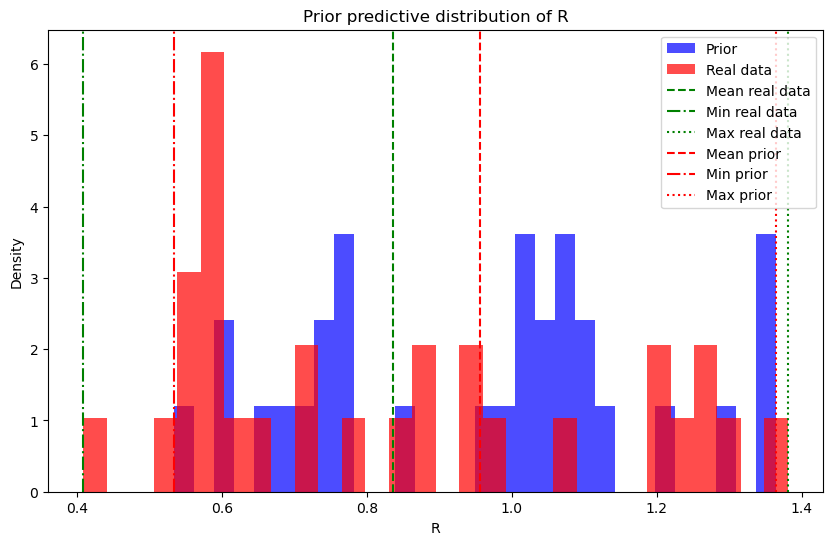

In [ ]:
#prior predictive check of R 
n = 1
size_prior = len(R_subsampled)
SpO2_prior, sigma_squared_prior, eps_hbo2_660_prior, eps_hbo2_940_prior, eps_hb_660_prior, eps_hb_940_prior = sample_prior(len(spo2_subsampled), n=n)
mean = (SpO2_prior * eps_hbo2_660_prior + (1 - SpO2_prior) * eps_hb_660_prior)  / (SpO2_prior * eps_hbo2_940_prior + (1 - SpO2_prior) * eps_hb_940_prior)

R_prior = np.zeros(size_prior)
for i in range(size_prior):
    R_prior[i] = norm.rvs(loc=mean[i], scale=np.sqrt(sigma_squared_prior))

t_prior = np.linspace(0, 1, size_prior)

plt.figure(figsize=(10, 6))
plt.hist(R_prior, bins=30, density=True, alpha=0.7, color='b', label='Prior')
plt.hist(R_subsampled, bins=30, density=True, alpha=0.7, color='r', label='Real data')
plt.axvline(np.mean(R_subsampled), color='g', linestyle='--', label='Mean real data')
plt.axvline(np.min(R_subsampled), color='g', linestyle='-.', label='Min real data')
plt.axvline(np.max(R_subsampled), color='g', linestyle=':', label='Max real data')
plt.axvline(np.mean(R_prior), color='r', linestyle='--', label='Mean prior')
plt.axvline(np.min(R_prior), color='r', linestyle='-.', label='Min prior')
plt.axvline(np.max(R_prior), color='r', linestyle=':', label='Max prior')
plt.title('Prior predictive distribution of R')
plt.xlabel('R')
plt.ylabel('Density')
plt.legend()
plt.show()

The mean, minimum, and maximum values appear to be fairly similar, indicating that our prior is a reasonable approximation. This is because the generated R values fall within a comparable range to the original R values and exhibit a similar distribution, as evidenced by the aligned mean and coverage of the entire range.

<div class="alert alert-success">
    
**Exercise**. Write a `log_posterior` function that returns the logarithm of the (unormalized) posterior probability density function,
$$
    p(\text{SpO2}_{1:T}, \sigma^2, \epsilon_\text{HbO2}(660 \text{nm}), \epsilon_\text{Hb}(660 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}), \epsilon_\text{HbO2}(940 \text{nm}) \mid R_{1:T}),
$$
using your previously defined priors.
    
</div>

In [35]:
def log_posterior(params, R, SpO2_sampled):
    SpO2 = params[:len(SpO2_sampled)]
    if(SpO2[0] > 1):
        SpO2 /= 100
    sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940 = params[len(SpO2_sampled):]
    
    log_ll = log_likelihood(R, SpO2, sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940)
    log_p = log_prior(SpO2, sigma_squared, eps_hbo2_660, eps_hbo2_940, eps_hb_660, eps_hb_940)
    
    return log_ll + log_p

<div class="alert alert-success">
    
**Exercise**. Use MCMC to compute the posterior distribution given the observed ratios $R_{1:T}$. The posterior distribution is computed on $5$ parameters and $T$ $\text{SpO2}$ values, where $T$ is the number of ratios you subsampled in the time series of ratios.

</div>

In [ ]:
#long to run, see 'parallel.py' for parallelized implementation
nwalkers = 150
ndim = 30 + 5
nsteps = 200000

pos = np.zeros((nwalkers, ndim))

for i in range(len(spo2_subsampled)):
    pos[:, i] = np.random.uniform(0.7, 1, nwalkers)

interval = 100
pos[:, len(spo2_subsampled)] = np.abs(0.02 + np.random.uniform(-0.01, 0.01, nwalkers))
pos[:, len(spo2_subsampled) + 1] = np.random.uniform(EPS_HBO2_660-interval, EPS_HBO2_660+interval, nwalkers)
pos[:, len(spo2_subsampled) + 2] = np.random.uniform(EPS_HBO2_940-interval, EPS_HBO2_940+interval, nwalkers)
pos[:, len(spo2_subsampled) + 3] = np.random.uniform(EPS_HB_660-interval, EPS_HB_660+interval, nwalkers)
pos[:, len(spo2_subsampled) + 4] = np.random.uniform(EPS_HB_940-interval, EPS_HB_940+interval, nwalkers)

SpO2_generated, sigma_squared_generated, eps_hbo2_660_generated, eps_hbo2_940_generated, eps_hb_660_generated, eps_hb_940_generated = sample_prior(len(spo2_subsampled), n=1)
SpO2_generated *= 100
parameters = (SpO2_generated, sigma_squared_generated, eps_hbo2_660_generated, eps_hbo2_940_generated, eps_hb_660_generated, eps_hb_940_generated)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(R_subsampled, spo2_subsampled))
sampler.run_mcmc(pos, nsteps, progress=True)

<div class="alert alert-success">
    
**Exercise**. Plot the resulting Markov chains for the parameters and for some input oximetry $\text{SpO2}$ and discuss their convergence in view of your choice of parametrization and choices of prior distributions. Discuss the mixing, agreement and auto-correlation of the Markov chains.
    
</div>

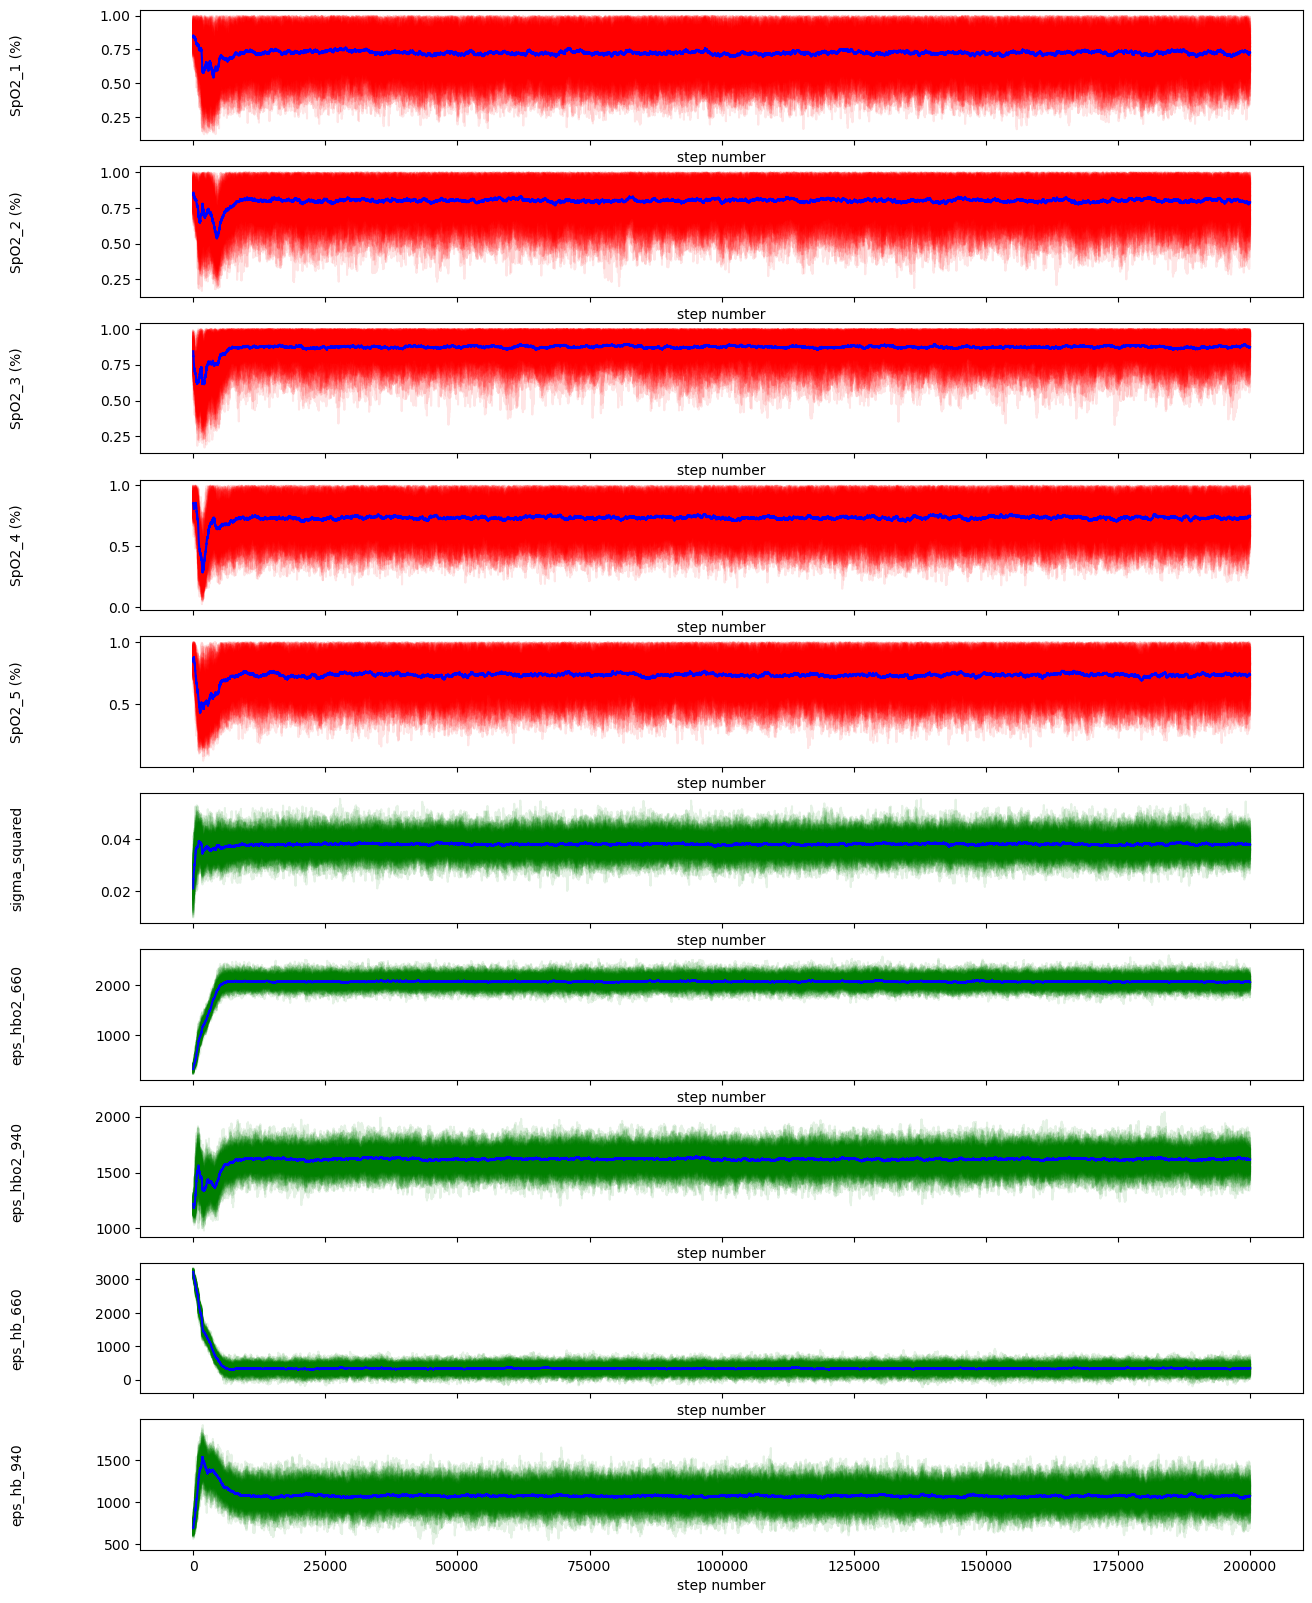

[1716.40711693 1787.42152995 1804.54733264 1764.22611759 1834.23205191
 1907.66818479 2034.59091509 1898.4375794  1843.67238395 2130.78761674
 2109.03871329 2128.69791219 1772.92286756 1675.44622469 1745.38979554
 1762.0125702  1819.3448513  1907.10100531 1656.80153222 1855.07919432
 1843.38829565 1814.57287687 1958.02669402 1980.7758248  1880.20388536
 2099.59774389 2142.83968342 2264.34533344 2155.1875146  1798.4426347
 1665.67846959 3069.82397105 2317.16118503 3104.79615675 2074.83504736]


In [52]:
with open("sampler", "rb") as file:
    sampler = pickle.load(file)

fig, axes = plt.subplots(10, figsize=(15, 20), sharex=True)
samples = sampler.get_chain()

j = 0
for i in range(5):
    ax = axes[j]
    ax.plot(samples[:, :, i*5], "r", alpha=0.1)
    ax.plot(np.mean(samples[:, :, i*5], axis=1), "b", alpha=1.0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_ylabel(f"SpO2_{i+1} (%)")
    ax.set_xlabel("step number")
    
    j += 1

lab = ['sigma_squared', 'eps_hbo2_660', 'eps_hbo2_940', 'eps_hb_660', 'eps_hb_940']
for i in range(5):
    ax = axes[j]
    ax.plot(samples[:, :, 30 + i], "g", alpha=0.1)
    ax.plot(np.mean(samples[:, :,30 + i], axis=1), "b", alpha=1.0)
    ax.yaxis.set_label_coords(-0.1, 0.5)
    ax.set_xlabel("step number")
    ax.set_ylabel(lab[i])
    
    j += 1

axes[-1].set_xlabel("step number")
plt.show()

try:
    tau = sampler.get_autocorr_time()
    print(tau)
except emcee.autocorr.AutocorrError:
    print('Autocorrelation time could not be computed')

Let’s analyze the different characteristics:
- Autocorrelation: With a long chain (200,000 steps and 150 walkers), we observe that the largest step after which the data is no longer correlated is approximately 3105.
- Mixing: The mixing appears to be good, as all the chains overlap and explore a similar space.
- Agreement: This varies. For SpO2, a large vertical space is explored, whereas the epsilon parameters at 660 nm show limited exploration. The sigma parameter lies somewhere in between.

Overall, the model appears to perform reasonably well based on the observed Markov chains.

<div class="alert alert-success">
    
**Exercise**. Plot the estimated posterior probability distribution of the parameters and discuss these results.
    
</div>

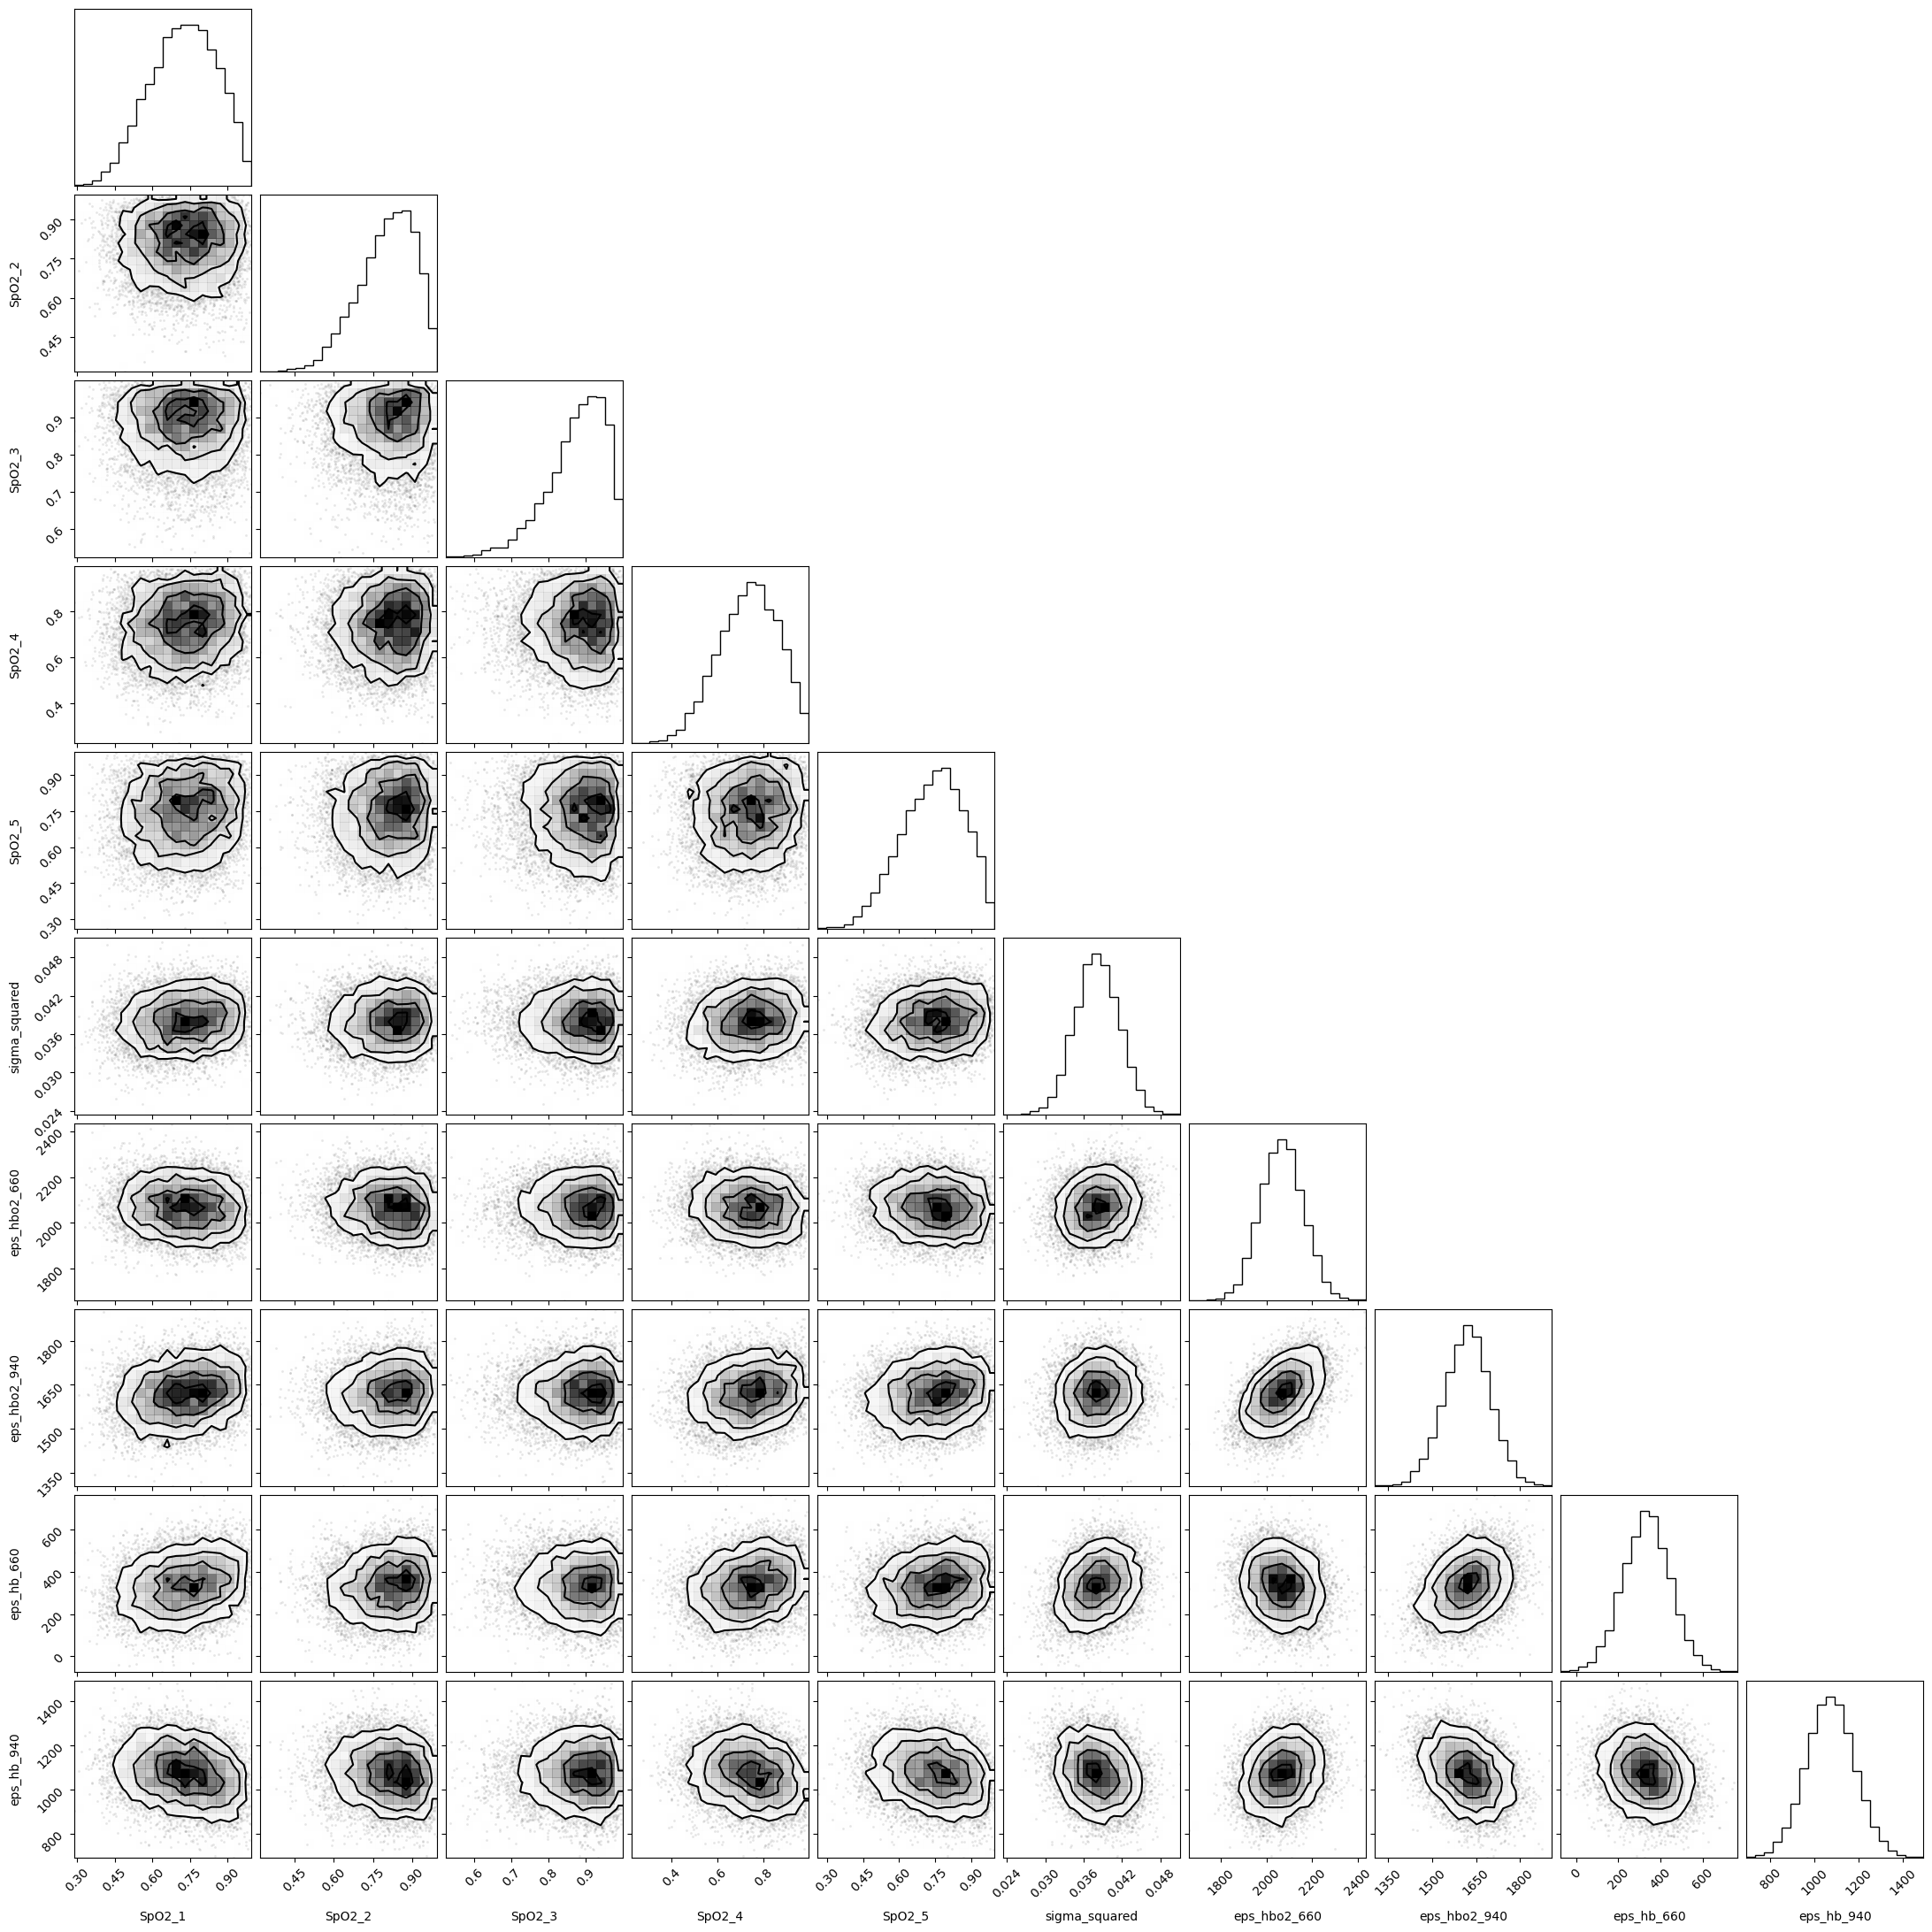

In [55]:
params = sampler.get_chain(discard=25000, thin=int(np.max(tau))+1, flat=True)

params_to_keep = np.zeros((params.shape[0], 10))

for i in range(5):
    params_to_keep[:, i] = params[:, i*5]

for i in range(5):
    params_to_keep[:, 5 + i] = params[:, 30 + i]

fig = corner.corner(params_to_keep, labels=["SpO2_1", "SpO2_2", "SpO2_3", "SpO2_4", "SpO2_5", "sigma_squared", "eps_hbo2_660", "eps_hbo2_940", "eps_hb_660", "eps_hb_940"])

When examining the corner plots, we observe that the results align closely with the priors we previously defined:
- SpO2 follows a skewed distribution, which is expected since we used a Beta distribution as its prior.
- The other parameters follow normal distributions, consistent with the priors we selected.

## Part 3: Criticize

<div class="alert alert-success">
    
**Exercise**. Plot the estimated posterior probability distribution of the oximetry ($\text{SpO2}$).
First, display this posterior probability distribution throughout the subsampled time series of input oximetry $R_{1:T}$, and compare it to the observed oximetry $\text{SpO2}_{1:T}$. Then, ignore the temporal aspect and display the marginal posterior probability distribution of oximetry, along with the marginal observed distribution of oximetry ($\text{SpO2}$). Discuss the results.
    
</div>

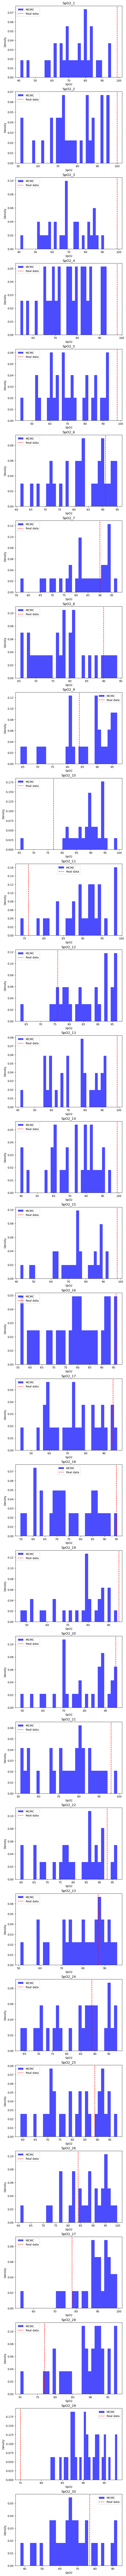

In [56]:
t_subsampled = t_spo2[::200]
spo2_mcmc = np.zeros((len(spo2_subsampled), len(t_subsampled)))

for i in range(len(spo2_subsampled)):
    spo2_mcmc[i] = params[:len(t_subsampled), i] * 100

fig, axes = plt.subplots(len(spo2_subsampled), figsize=(7, 170))

for i in range(len(spo2_subsampled)):
    ax = axes[i]
    ax.hist(spo2_mcmc[i], bins=30, density=True, alpha=0.7, color='b', label='MCMC')
    ax.axvline(spo2_subsampled[i], color='r', linestyle='--', label='Real data')
    ax.set_title(f'SpO2_{i+1}')
    ax.set_xlabel('SpO2')
    ax.set_ylabel('Density')
    ax.legend()
    
plt.show()

The predictions are less accurate when SpO2 is close to the extreme values of 75% or 100%, as the real values often fall outside the predicted range in these cases. However, for intermediate SpO2 values, the real data aligns well with the predictions, which is a positive outcome. Overall, the model struggles with extreme values but performs reasonably well for mid-range values.

<div class="alert alert-success">
    
**Exercise**. Evaluate the posterior predictive distribution of $R_{1:T}$. Discuss the results.
        
</div>

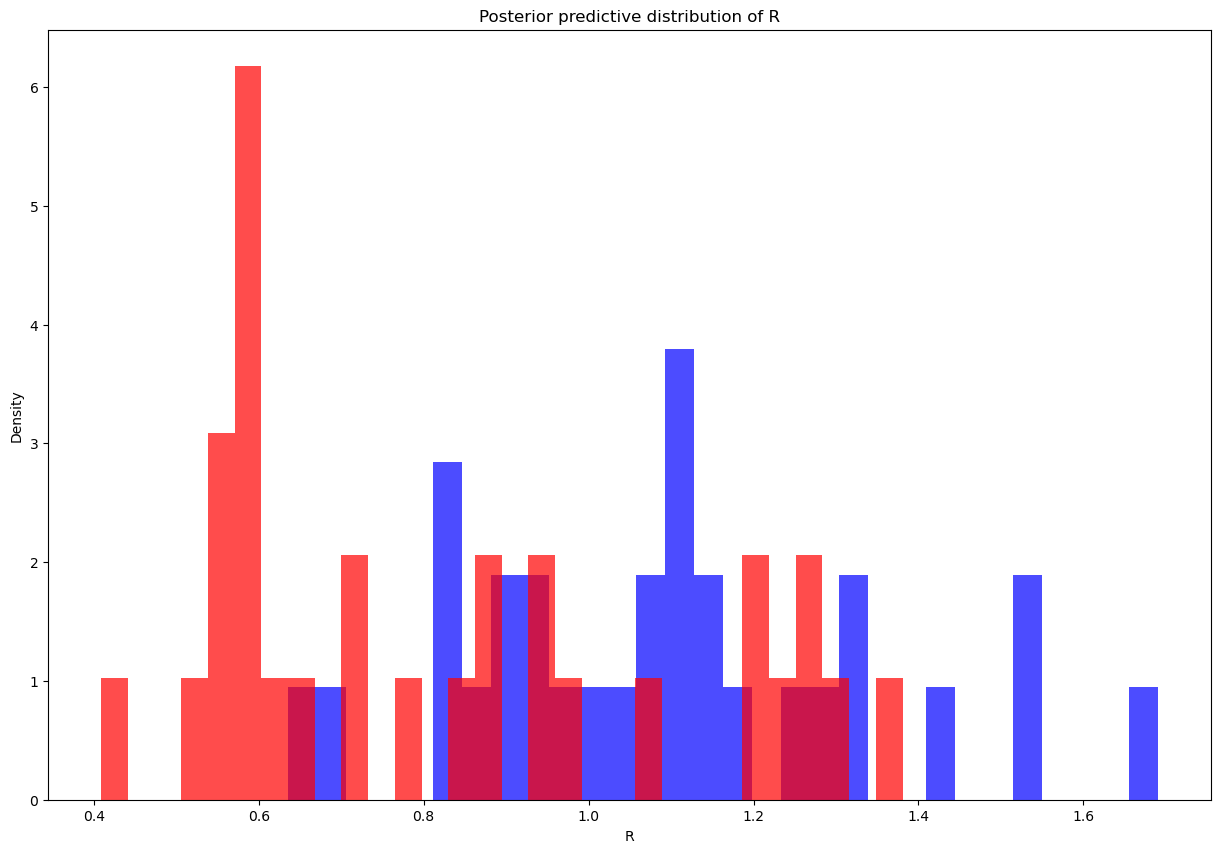

In [59]:
#posterior predictive check of R
size_posterior = len(R_subsampled)

SpO2_posterior = np.zeros(size_posterior)
sigma_squared_posterior = 0
eps_hbo2_660_posterior = 0
eps_hbo2_940_posterior = 0
eps_hb_660_posterior = 0
eps_hb_940_posterior = 0

for i in range(size_posterior):
    SpO2_posterior[i] = np.mean(params[:, i])
    
sigma_squared_posterior = np.mean(params[:, size_posterior])
eps_hbo2_660_posterior = np.mean(params[:, size_posterior + 1])
eps_hbo2_940_posterior = np.mean(params[:, size_posterior + 2])
eps_hb_660_posterior = np.mean(params[:, size_posterior + 3])
eps_hb_940_posterior = np.mean(params[:, size_posterior + 4])
    
R_posterior = sample_likelihood(SpO2_posterior, sigma_squared_posterior, 
                                eps_hbo2_660_posterior, eps_hbo2_940_posterior, 
                                eps_hb_660_posterior, eps_hb_940_posterior, n=1)

plt.figure(figsize=(15, 10))
plt.hist(R_posterior, bins=30, density=True, alpha=0.7, color='b')
plt.hist(R_subsampled, bins=30, density=True, alpha=0.7, color='r')
plt.title('Posterior predictive distribution of R')
plt.xlabel('R')
plt.ylabel('Density')
plt.show()

The posterior predictive distribution aligns well with the observed data in the central range of R (0.8 to 1.2), indicating that the model captures the main trends effectively. However, discrepancies arise at the extremes: the predictive distribution overestimates density below 0.6 and includes regions above 1.4 where there is little to no observed data. This suggests that the model may introduce additional uncertainty, particularly at the tails. Overall, the predictions are reasonable but could be improved.

<div class="alert alert-success">
    
**Exercise**. Evaluate the posterior predictive distributions of test quantities (statistics) of $R_{1:T}$. Discuss the results.
        
</div>

Mean of R posterior: 1.0943806449331428
Standard deviation of R posterior: 0.24361595581329476
Median of R posterior: 1.095971095901222
25th percentile of R posterior: 0.9171248395239558
75th percentile of R posterior: 1.2402525157978792

Mean of R subsampled: 0.8356848451680192
Standard deviation of R subsampled: 0.28430264752996043
Median of R subsampled: 0.7494427319166241
25th percentile of R subsampled: 0.5929873142967794
75th percentile of R subsampled: 1.047493669110757


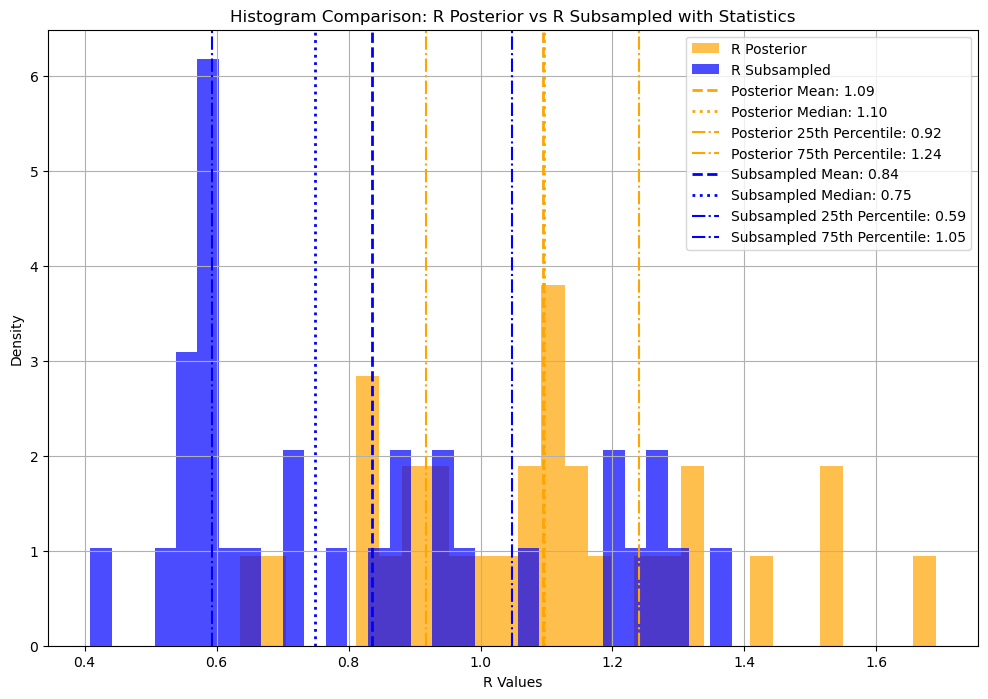

In [62]:
#posterior predictive distributions of test quantities (statistics) of R
mean_posterior = np.mean(R_posterior)
std_posterior = np.std(R_posterior)
median_posterior = np.median(R_posterior)
percentile_25_posterior = np.percentile(R_posterior, 25)
percentile_75_posterior = np.percentile(R_posterior, 75)

print(f'Mean of R posterior: {mean_posterior}')
print(f'Standard deviation of R posterior: {std_posterior}')
print(f'Median of R posterior: {median_posterior}')
print(f'25th percentile of R posterior: {percentile_25_posterior}')
print(f'75th percentile of R posterior: {percentile_75_posterior}')
print()

real_mean = np.mean(R_subsampled)
real_std = np.std(R_subsampled)
real_median = np.median(R_subsampled)
real_percentile_25 = np.percentile(R_subsampled, 25)
real_percentile_75 = np.percentile(R_subsampled, 75)

print(f'Mean of R subsampled: {real_mean}')
print(f'Standard deviation of R subsampled: {real_std}')
print(f'Median of R subsampled: {real_median}')
print(f'25th percentile of R subsampled: {real_percentile_25}')
print(f'75th percentile of R subsampled: {real_percentile_75}')

plt.figure(figsize=(12, 8))
plt.hist(R_posterior, bins=30, alpha=0.7, label='R Posterior', color='orange', density=True)
plt.hist(R_subsampled, bins=30, alpha=0.7, label='R Subsampled', color='blue', density=True)

# Annotate statistics on the plot
plt.axvline(mean_posterior, color='orange', linestyle='--', linewidth=2, label=f'Posterior Mean: {mean_posterior:.2f}')
plt.axvline(median_posterior, color='orange', linestyle=':', linewidth=2, label=f'Posterior Median: {median_posterior:.2f}')
plt.axvline(percentile_25_posterior, color='orange', linestyle='-.', linewidth=1.5, label=f'Posterior 25th Percentile: {percentile_25_posterior:.2f}')
plt.axvline(percentile_75_posterior, color='orange', linestyle='-.', linewidth=1.5, label=f'Posterior 75th Percentile: {percentile_75_posterior:.2f}')

plt.axvline(real_mean, color='blue', linestyle='--', linewidth=2, label=f'Subsampled Mean: {real_mean:.2f}')
plt.axvline(real_median, color='blue', linestyle=':', linewidth=2, label=f'Subsampled Median: {real_median:.2f}')
plt.axvline(real_percentile_25, color='blue', linestyle='-.', linewidth=1.5, label=f'Subsampled 25th Percentile: {real_percentile_25:.2f}')
plt.axvline(real_percentile_75, color='blue', linestyle='-.', linewidth=1.5, label=f'Subsampled 75th Percentile: {real_percentile_75:.2f}')

# Plot settings
plt.title('Histogram Comparison: R Posterior vs R Subsampled with Statistics')
plt.xlabel('R Values')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

The posterior predictive distribution aligns moderately well with the subsampled data, especially in the central regions of R. However, it shows a bias toward higher R values, with a mean (1.09) and median (1.10) that exceed those of the subsampled data (mean: 0.84, median: 0.75). Additionally, the posterior predictive distribution has a broader spread, as indicated by its wider 25th and 75th percentiles, suggesting an overestimation of uncertainty. While the model captures overall trends it could use some improvements.

<div class="alert alert-success">
    
**Exercise**. Evaluate the performance of the model quantitatively. Motivate your metric(s) and discuss.
        
</div>

In [63]:
MSE = mean_squared_error(R_subsampled, R_posterior)
MAE = mean_absolute_error(R_subsampled, R_posterior)

print(f'Mean Squared Error: {MSE}')
print(f'Mean Absolute Error: {MAE}')

Mean Squared Error: 0.22129382737789507
Mean Absolute Error: 0.41479813554519224


The model's performance, with a Mean Squared Error (MSE) of 0.221 and a Mean Absolute Error (MAE) of 0.415, shows moderate accuracy. The MSE, which emphasizes larger errors, points to potential issues with outliers, while the MAE gives a more balanced view of the average error. These relatively low values suggest the model captures the main patterns in the data well but could be improved by addressing larger deviations which is consistent with the previous remarks.

<div class="alert alert-success">
    
**Exercise**. Criticize the model and propose an improvement. Implementing this improvement is not required.
        
</div>

The model performs reasonably well but has notable issues, including poor handling of extreme R values and overestimation of variability, as seen in the posterior predictive distribution compared to the observed data. Error metrics, while moderate (MSE: 0.221, MAE: 0.415), indicate room for improvement. To address these issues, the priors could be refined to better reflect the distribution of the data, the likelihood could be adjusted to better handle variability at extremes meaning that a normal distribution of R may not be a very good approximation. Also, truncated priors could be introduced to constrain predictions within the observed data range. These improvements would improve robustness and predictive accuracy.